### EDA

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [171]:
df = pd.read_csv('dataset/train.csv.zip')

In [172]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [173]:
df.shape

(404290, 6)

In [174]:
df = df.iloc[:10000]

In [175]:
df.shape

(10000, 6)

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            10000 non-null  int64 
 1   qid1          10000 non-null  int64 
 2   qid2          10000 non-null  int64 
 3   question1     10000 non-null  object
 4   question2     10000 non-null  object
 5   is_duplicate  10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 468.9+ KB


<Axes: xlabel='is_duplicate'>

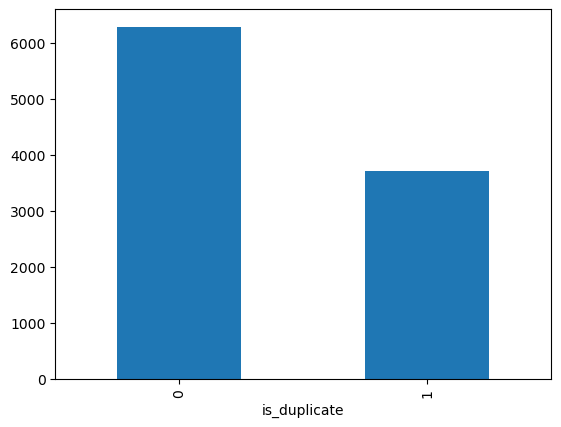

In [177]:
df['is_duplicate'].value_counts().plot(kind='bar')

In [178]:
print(df['question1'].duplicated().value_counts())
print(df['question2'].duplicated().value_counts())

question1
False    9813
True      187
Name: count, dtype: int64
question2
False    9790
True      210
Name: count, dtype: int64


### Text Preprocessing

In [179]:
import string
from nltk import download
from nltk.stem import PorterStemmer
import re

download('stopwords')
def preprocess(text):
    #Lowercase
    text = text.lower()

    #Remove html tags
    text = re.sub(r'<.*?>', ' ', text)

    #Remove other Punctuation
    text = re.sub(r'[^\w]', ' ', text)

    #Stemming 
    stemmer = PorterStemmer()
    text = stemmer.stem(text)
    

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sudarshan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [180]:
preprocess('is this not greatest movie ive seen <b> do you like this   ?')

'is this not greatest movie ive seen   do you like this    '

In [181]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [182]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0


### Feature extraction

In [183]:
### Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['question1', 'question2']], df['is_duplicate'], test_size=0.2)

#### Features to add
1. Length of first question
2. Length of second question
3. No of words q1
4. No of words q2
5. Common words ratio (no of common words / total no of words)
6. Is first word same
7. Is last word same
8. Fuzzy ratio
9. Fuzzy Partial Ratio
10. Fuzzy sort ratio
11. Fuzzy Set ratio
12. TFIDF for 10000 most repeated words


In [184]:
from fuzzywuzzy import fuzz

def get_features(text1, text2):
    # Length of questions
    len1 = len(text1)
    len2 = len(text2)

    #No of words
    word_len1 = len(text1.split())
    word_len2 = len(text2.split())

    # No of common words
    set1 = set(text1.split())
    set2 = set(text2.split())
    common_word_ratio =  len(set1 & set2) / (word_len1 + word_len2)

    #First and last words
    f_word_same = 0
    l_word_same = 0
    if(len(text1.split()) and len(text2.split())):
        f_word_same = int(text1.split()[0] == text2.split()[0])
        l_word_same = int(text1.split()[-1] == text2.split()[-1])

    #Fuzzywuzzy
    fuzz_ratio = fuzz.ratio(text1, text2)
    fuzz_partial = fuzz.partial_ratio(text1, text2)
    fuzz_sort = fuzz.token_sort_ratio(text1, text2)
    fuzz_set = fuzz.token_set_ratio(text1, text2)

    return [len1, len2, word_len1, word_len2, common_word_ratio, f_word_same, l_word_same, fuzz_ratio, fuzz_partial, fuzz_sort, fuzz_set]

In [185]:
len_features = ['len1', 'len2', 'word_len1', 'word_len_2', 'common_words_ratio', 'f_word_same', 'l_word_same','fuzz_ratio', 'f_partial', 'f_sort', 'f_set']
X_train[len_features] = X_train.apply(lambda row: get_features(row['question1'], row['question2']), axis=1, result_type='expand')

In [186]:
X_train.shape

(8000, 13)

In [187]:
#TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_vectorized = vectorizer.fit_transform(X_train['question1'] + X_train['question2']).toarray()

In [188]:
X_vectorized = pd.DataFrame(X_vectorized, columns=vectorizer.get_feature_names_out())

In [189]:
X_vectorized.shape

(8000, 10000)

In [190]:
X_train = pd.concat([X_train.reset_index(drop=True),X_vectorized], axis=1)

In [191]:
X_train.shape

(8000, 10013)